In [40]:
import sys
import os
import time
import numpy as np
from psutil import virtual_memory
import multiprocessing
import subprocess
from scipy import stats

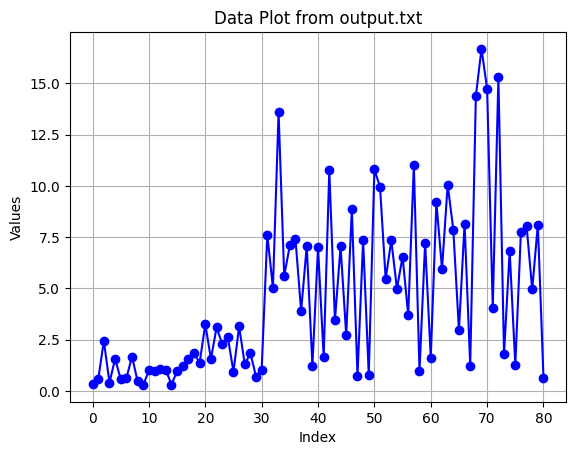

In [51]:
import matplotlib.pyplot as plt

# Read data from output.txt
with open('output/output.txt', 'r') as file:
    data = [float(line.strip()) for line in file]

# Plot the data
plt.plot(data[1:], marker='o', linestyle='-', color='b')
plt.title('Data Plot from output.txt')
plt.xlabel('Index')
plt.ylabel('Values')
plt.grid(True)
plt.show()

### Project setup :
You should try to set it up without the "capture" flag to see the output if error.

In [15]:
%%capture
!./clean.sh > /dev/null
!cd harness & &./build.sh & & cd..  # Build harness
!cd masstree & &./build.sh & & cd..  # Build masstree
#!cd silo && ./build.sh && cd .. # Build silo
#!cd shore && ./build.sh && cd .. # Build shore

In [ ]:
def parse_latencies():
    pass

In [19]:
configurations = ['integrated', 'loopback', 'networked']

NTHREADS = 1
WARMUPREQS = 14000
TBENCH_MINSLEEPNS = 10000
MAXREQS = 1000000

# Load is the number of query/second
min_qps = 1000
max_qps = 10000
steps = 1

workload = np.linspace(min_qps, max_qps, steps, dtype=int)

In [43]:
# Masstree -
mem = virtual_memory()
ram = round(mem.total / 1024 ** 3)
cpu = multiprocessing.cpu_count()

coreOffStatements = [r"echo 0 | sudo tee /sys/devices/system/cpu/cpu{}/online".format(i) for i in range(cpu)]
coreOnStatements = [r"echo 1 | sudo tee /sys/devices/system/cpu/cpu{}/online".format(i) for i in range(cpu)]

print("{} cores and {} memory".format(cpu, ram))

for i, load in enumerate(workload):
    print(f"Run {i + 1}, QPS = {load}")

    #for e in coreOnStatements:
    #    os.system(e)
    #ctr = cpu

    #while ctr >= 1:
    #print(ctr, "cores...")

    command = f'cd masstree && TBENCH_QPS={load} TBENCH_MAXREQS={MAXREQS} TBENCH_WARMUPREQS={WARMUPREQS} ' \
              f'TBENCH_MINSLEEPNS={TBENCH_MINSLEEPNS} ./mttest_integrated -j{NTHREADS} mycsba masstree > masstree.txt'
    subprocess.run(command, shell=True)
    print("Done")

    # TODO print latencies

    #os.system(coreOffStatements[ctr - 1])
    #os.system(coreOffStatements[ctr - 2])
    #os.system(coreOffStatements[ctr - 3])
    #os.system(coreOffStatements[ctr - 4])
    #ctr -= 4

    #for e in coreOnStatements:
    #   os.system(e)

    # 1. Run the workload
    # 2. Parse latencies
    # 3. Plot latencies



12 cores and 15 memory
Run 1, QPS = 1000


sudo: a terminal is required to read the password; either use the -S option to read from standard input or configure an askpass helper
sudo: a password is required
sudo: a terminal is required to read the password; either use the -S option to read from standard input or configure an askpass helper
sudo: a password is required
sudo: a terminal is required to read the password; either use the -S option to read from standard input or configure an askpass helper
sudo: a password is required
sudo: a terminal is required to read the password; either use the -S option to read from standard input or configure an askpass helper
sudo: a password is required
sudo: a terminal is required to read the password; either use the -S option to read from standard input or configure an askpass helper
sudo: a password is required
sudo: a terminal is required to read the password; either use the -S option to read from standard input or configure an askpass helper
sudo: a password is required
sudo: a terminal

KeyboardInterrupt: 

In [ ]:
import sys
import os
import time

from psutil import virtual_memory
import multiprocessing
import numpy as np
from scipy import stats

paths = [r"../masstree/lats.bin"]  # , r"../silo/lats.bin"]
executeStatement = r"(cd ../{}/ ; sudo ./run.sh > {}.txt)"
coreOffStatements = [r"echo 0 | sudo tee /sys/devices/system/cpu/cpu{}/online".format(i) for i in range(cpu)]
coreOnStatements = [r"echo 1 | sudo tee /sys/devices/system/cpu/cpu{}/online".format(i) for i in range(cpu)]


class Lat(object):
    def __init__(self, fileName):
        f = open(fileName, 'rb')
        a = np.fromfile(f, dtype=np.uint64)
        self.reqTimes = a.reshape((a.shape[0] // 3, 3))
        f.close()

    def parseQueueTimes(self):
        return self.reqTimes[:, 0]

    def parseSvcTimes(self):
        return self.reqTimes[:, 1]

    def parseSojournTimes(self):
        return self.reqTimes[:, 2]


def getLatPct(latsFile):
    assert os.path.exists(latsFile)

    latsObj = Lat(latsFile)
    temp_cpu = multiprocessing.cpu_count()
    qTimes = [l / 1e6 for l in latsObj.parseQueueTimes()]
    svcTimes = [l / 1e6 for l in latsObj.parseSvcTimes()]
    sjrnTimes = [l / 1e6 for l in latsObj.parseSojournTimes()]
    f = open('output/lats-{}-{}-{}.txt'.format(latsFile[3:-9], temp_cpu, ram), 'w')
    f.write('%12s | %12s | %12s\n\n'
            % ('QueueTimes', 'ServiceTimes', 'SojournTimes'))

    for (q, svc, sjrn) in zip(qTimes, svcTimes, sjrnTimes):
        f.write("%12s | %12s | %12s\n"
                % ('%.3f' % q, '%.3f' % svc, '%.3f' % sjrn))
    f.close()

    f = open('output/{}-{}-{}.txt'.format(latsFile[3:-9], temp_cpu, ram), 'w')
    for i in sjrnTimes:
        f.write('%.3f\n' % i)
    f.close()

    p95 = stats.scoreatpercentile(sjrnTimes, 95)
    maxLat = max(sjrnTimes)
    print("95th percentile latency %.3f ms | max latency %.3f ms" % (p95, maxLat))


def run():
    print("Executing...")
    for e in coreOnStatements:
        os.system(e)
    ctr = cpu

    params = sys.argv[1:]
    params.sort()
    applications = params[params.index('-e') + 1:]
    for app in applications:
        while ctr >= 1:
            print(ctr, "cores...")
            runStatement = executeStatement.format(
                app, app + '-' + str(ctr) + '-' + str(ram))
            print(runStatement)
            time.sleep(15)
            os.system(runStatement)
            generate()
            os.system(coreOffStatements[ctr - 1])
            os.system(coreOffStatements[ctr - 2])
            os.system(coreOffStatements[ctr - 3])
            os.system(coreOffStatements[ctr - 4])
            ctr -= 4

    for e in coreOnStatements:
        os.system(e)


def generate():
    print("Generating Output Files...")
    for p in paths:
        print(p)
        latsFile = p
        getLatPct(latsFile)


params = sys.argv[1:]  # -b build, -e execute run.sh, -o generate output
params.sort()
for parameter in params:
    if parameter == '-e':
        run()
    if parameter == "-o":
        generate()
